**Names:** Tia (2205775), Bram Schork (2205684), Jacob Alderete (2206035)

# Imports

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# Problem 1

## Part (a)

In [ ]:
# 1) Load the CRSP data (from the ZIP archive) and parse dates
crsp = pd.read_csv('crsp_1926_2020.zip', 
                   compression='zip',
                   parse_dates=['date'],
                   dtype={'SHRCD': 'Int64', 'EXCHCD': 'Int64'})

# 2) Keep only ordinary/common shares (shrcd = 10 or 11)
mask_shares = crsp['SHRCD'].isin([10, 11])

# 3) Keep only NYSE, AMEX, NASDAQ listings (exchcd = 1, 2, 3)
mask_exch = crsp['EXCHCD'].isin([1, 2, 3])

crsp_clean = crsp.loc[mask_shares & mask_exch].copy()

# 4) Set negative prices to NA
crsp_clean['PRC'] = crsp_clean['PRC'].where(crsp_clean['PRC'] >= 0, pd.NA)

# 5) sanity‐check
print(f"Raw CRSP rows:  {len(crsp):,}")
print(f"Clean CRSP rows:{len(crsp_clean):,}")
display(crsp_clean.head())

Raw CRSP rows:  4,705,169
Clean CRSP rows:3,630,644


,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT
1,10000,1986-01-31,10,3,NaN,C,3680.0
2,10000,1986-02-28,10,3,NaN,-0.257143,3680.0
3,10000,1986-03-31,10,3,NaN,0.365385,3680.0
4,10000,1986-04-30,10,3,NaN,-0.098592,3793.0
5,10000,1986-05-30,10,3,NaN,-0.222656,3793.0


## Part (b)

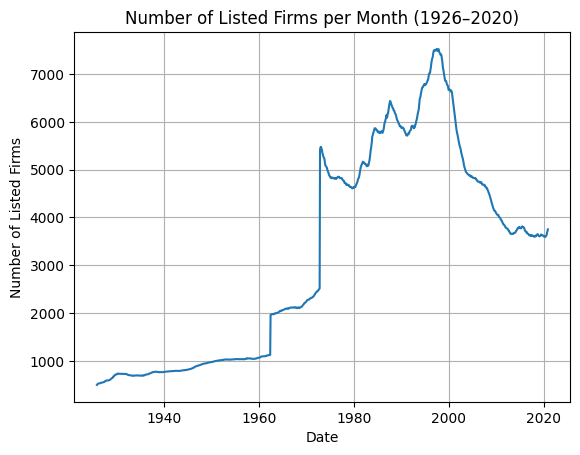

In [71]:
# 1) Convert dates to a monthly period
crsp_clean['month'] = crsp_clean['date'].dt.to_period('M')

# 2) Count unique firms (PERMNO) in each month
firms_per_month = crsp_clean.groupby('month')['PERMNO'].nunique()

# 3) Convert the PeriodIndex back to timestamps for plotting
firms_per_month.index = firms_per_month.index.to_timestamp()

# 4) Plot
plt.figure()
plt.plot(firms_per_month.index, firms_per_month.values)
plt.xlabel('Date')
plt.ylabel('Number of Listed Firms')
plt.title('Number of Listed Firms per Month (1926–2020)')
plt.grid(True)
plt.show()

# Problem 2

## Part (a)

In [72]:
# ———————————————
# 1) (Re‑)Load & clean CRSP
# ———————————————
crsp = pd.read_csv('crsp_1926_2020.zip', parse_dates=['date'])
crsp = crsp.loc[
    crsp['SHRCD'].isin([10,11]) &
    crsp['EXCHCD'].isin([1,2,3])
].copy()
crsp['PRC'] = crsp['PRC'].where(crsp['PRC'] >= 0, pd.NA)
# — coerce returns into floats, turn any 'C' or other bad codes into NaN —
crsp['RET'] = pd.to_numeric(crsp['RET'], errors='coerce')
# (optional) drop rows with no return or no market equity
crsp = crsp.dropna(subset=['RET', 'PRC', 'SHROUT'])

# ———————————————
# 2) Compute market equity (ME)
# ———————————————
# dividing by 1,000 just rescales into millions; optional
crsp['ME'] = crsp['PRC'] * crsp['SHROUT'] / 1000

# ———————————————
# 3) Assign size deciles each month
# ———————————————
crsp['size_rank']   = crsp.groupby('date')['ME'].rank(pct=True)
crsp['size_decile'] = np.ceil(crsp['size_rank'] * 10)
crsp = crsp.dropna(subset=['size_decile'])

# ———————————————
# 4) Within each (date,decile) compute weights
# ———————————————
def _assign_w(df):
    df = df.copy()
    df['w_eq']  = 1.0 / len(df)
    df['w_val'] = df['ME'] / df['ME'].sum()
    return df

crsp = crsp.groupby(['date','size_decile'], group_keys=False).apply(_assign_w)

# ———————————————
# 5) Lag decile & weights by one month
# ———————————————
crsp['decile_lag'] = crsp.groupby('PERMNO')['size_decile'].shift(1)
crsp['w_eq_lag']   = crsp.groupby('PERMNO')['w_eq'].shift(1)
crsp['w_val_lag']  = crsp.groupby('PERMNO')['w_val'].shift(1)

# ———————————————
# 6) Compute weighted returns
# ———————————————
crsp['ret_eq']  = crsp['w_eq_lag']  * crsp['RET']
crsp['ret_val'] = crsp['w_val_lag'] * crsp['RET']

# ———————————————
# 7) Aggregate into decile‐portfolio returns
# ———————————————
ew_size = (
    crsp
    .groupby(['date','decile_lag'])['ret_eq']
    .sum()
    .unstack()    # columns 1–10 = equal‐weighted decile returns
    * 100         # convert to percent
)

vw_size = (
    crsp
    .groupby(['date','decile_lag'])['ret_val']
    .sum()
    .unstack()    # columns 1–10 = value‐weighted decile returns
    * 100
)

/var/folders/vs/b51fgl4x6bsbtncxc8sg87c40000gn/T/ipykernel_15543/3844352431.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crsp = crsp.groupby(['date','size_decile'], group_keys=False).apply(_assign_w)


In [73]:
ew_size

decile_lag,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
date,,,,,,,,,,
1926-02-27,-6.229295,-3.414426,-7.824514,-6.290758,-6.785022,-6.103555,-5.209176,-5.583524,-2.416238,-2.224797
1926-03-31,-15.827153,-13.603903,-12.779780,-10.699399,-10.235801,-10.192216,-11.870795,-5.139165,-6.841431,-6.519985
1926-04-30,0.907911,1.574623,-0.196736,4.564445,4.468662,2.697481,5.305059,3.008959,3.592823,3.330242
1926-05-28,-2.610104,-1.129308,2.825231,0.783148,-1.461541,2.052207,1.243719,0.766050,1.013960,1.698598
1926-06-30,4.768647,8.687964,6.655102,6.062040,3.817210,5.231134,6.254314,4.435769,5.268095,5.874462
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,-0.600565,2.102848,5.889660,8.203049,6.258390,6.112859,5.350280,5.509934,4.863331,4.419874
2020-09-30,-0.904210,-0.714967,-2.273452,-2.661926,-4.598571,-3.951170,-3.574000,-3.856081,-1.338856,-1.851737
2020-10-30,1.009761,-1.518943,-0.948245,0.728229,1.683723,2.088935,3.988691,2.391600,0.970482,-1.198564


In [74]:
vw_size

decile_lag,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
date,,,,,,,,,,
1926-02-27,-7.285312,-3.348647,-8.257944,-6.173528,-6.803391,-6.147286,-5.200756,-5.629710,-2.047690,-2.317818
1926-03-31,-14.939348,-13.457020,-12.830480,-10.756289,-10.279541,-10.178001,-11.524991,-5.189405,-6.816590,-5.442359
1926-04-30,3.234297,1.578171,0.059931,4.436656,4.096481,2.699240,5.110399,2.880124,3.799966,3.549711
1926-05-28,0.291430,-1.302880,2.675216,0.840349,-1.407352,2.127212,1.267058,0.884317,0.963910,1.569643
1926-06-30,6.092173,9.049757,6.740345,6.117220,3.989304,5.608473,6.449319,4.500542,5.215586,5.539367
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,-0.684682,2.249678,6.124167,8.259524,6.364253,6.089135,5.237955,5.359273,4.535157,8.164306
2020-09-30,-1.699857,-0.812127,-2.202455,-2.859462,-4.902944,-3.869233,-3.575385,-3.879305,-1.187207,-3.866841
2020-10-30,-0.275467,-0.986064,-0.892417,0.757187,1.787699,2.346598,4.076413,2.343820,0.742891,-2.827867


## Part (b)

In [75]:
# 1) Compute the mean monthly return for each decile
ew_means = ew_size.mean()   # Series indexed 1–10
vw_means = vw_size.mean()

# 2) Display them
print("Equal‑Weighted Mean Returns by Decile (1=Small … 10=Big):")
print(ew_means.round(3))


Equal‑Weighted Mean Returns by Decile (1=Small … 10=Big):
decile_lag
1.0     3.110
2.0     1.509
3.0     1.337
4.0     1.273
5.0     1.267
6.0     1.216
7.0     1.162
8.0     1.092
9.0     1.071
10.0    0.925
dtype: float64


In [76]:
print("\nValue‑Weighted Mean Returns by Decile:")
print(vw_means.round(3))


Value‑Weighted Mean Returns by Decile:
decile_lag
1.0     2.471
2.0     1.486
3.0     1.344
4.0     1.269
5.0     1.264
6.0     1.218
7.0     1.161
8.0     1.084
9.0     1.065
10.0    0.913
dtype: float64


In [77]:
# 3) Check monotonicity
print("\nEW monotonic ↓?", ew_means.is_monotonic_decreasing)
print("VW monotonic ↓?", vw_means.is_monotonic_decreasing)


EW monotonic ↓? True
VW monotonic ↓? True


## Part (c)

In [78]:
# 1) Construct the long–short series
smb_ew = ew_size[1] - ew_size[10]
smb_vw = vw_size[1] - vw_size[10]

# 2) Compute statistics
for name, series in [
    ('Equal‑Weighted SMB', smb_ew),
    ('Value‑Weighted SMB', smb_vw)
]:
    mean  = series.mean()           # average monthly return (%)
    vol   = series.std()            # monthly volatility (%)
    sharpe = mean / vol             # monthly Sharpe ratio

    print(f"{name}:")
    print(f"  Mean   = {mean:.3f}%")
    print(f"  Vol    = {vol:.3f}%")
    print(f"  Sharpe = {sharpe:.3f}\n")

Equal‑Weighted SMB:
  Mean   = 2.185%
  Vol    = 15.055%
  Sharpe = 0.145

Value‑Weighted SMB:
  Mean   = 1.558%
  Vol    = 12.915%
  Sharpe = 0.121



## Part (d)

In [79]:
# 1) Load FF3 factors (skip header rows)
ff3 = pd.read_csv(
    'F-F_Research_Data_Factors_CSV.zip',
    compression='zip',
    skiprows=3,
    nrows=1182
)
# Rename & parse date
ff3 = ff3.rename(columns={'Unnamed: 0':'Date'})
ff3['Date'] = pd.to_datetime(ff3['Date'], format='%Y%m').dt.to_period('M').dt.to_timestamp()
ff3 = ff3[['Date','Mkt-RF','SMB','HML','RF']]
ff3 = ff3.astype({
    'Mkt-RF':'float64',
    'SMB':   'float64',
    'HML':   'float64',
    'RF':    'float64'
})

# 2) Build a DataFrame of your SMB series
port = pd.DataFrame({
    'Date': smb_ew.index.to_period('M').to_timestamp(),
    'SMB_ew': smb_ew.values,
    'SMB_vw': smb_vw.values
})

# 3) Merge with factors
df = port.merge(ff3, on='Date', how='inner')

# 4) Compute excess returns
df['EW_excess'] = df['SMB_ew'] - df['RF']
df['VW_excess'] = df['SMB_vw'] - df['RF']

# 5) CAPM regressions
X_capm = sm.add_constant(df['Mkt-RF'])
capm_ew = sm.OLS(df['EW_excess'], X_capm).fit()
capm_vw = sm.OLS(df['VW_excess'], X_capm).fit()

# 6) FF3 regressions
X_ff3 = sm.add_constant(df[['Mkt-RF','SMB','HML']])
ff3_ew = sm.OLS(df['EW_excess'], X_ff3).fit()
ff3_vw = sm.OLS(df['VW_excess'], X_ff3).fit()

# 7) Print summaries
print("=== CAPM (Equal‑Weighted) ===")
print(capm_ew.summary(), "\n")

=== CAPM (Equal‑Weighted) ===
                            OLS Regression Results                            
Dep. Variable:              EW_excess   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     231.7
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           9.47e-48
Time:                        23:29:15   Log-Likelihood:                -4581.7
No. Observations:                1134   AIC:                             9167.
Df Residuals:                    1132   BIC:                             9177.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1507 

In [80]:
print("=== FF3 (Equal‑Weighted) ===")
print(ff3_ew.summary(), "\n")

=== FF3 (Equal‑Weighted) ===
                            OLS Regression Results                            
Dep. Variable:              EW_excess   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     529.7
Date:                Fri, 18 Apr 2025   Prob (F-statistic):          6.93e-215
Time:                        23:29:15   Log-Likelihood:                -4189.4
No. Observations:                1134   AIC:                             8387.
Df Residuals:                    1130   BIC:                             8407.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6094  

In [81]:
print("=== CAPM (Value‑Weighted) ===")
print(capm_vw.summary(), "\n")

=== CAPM (Value‑Weighted) ===
                            OLS Regression Results                            
Dep. Variable:              VW_excess   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     274.4
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           2.34e-55
Time:                        23:29:15   Log-Likelihood:                -4390.6
No. Observations:                1134   AIC:                             8785.
Df Residuals:                    1132   BIC:                             8795.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5797 

In [82]:
print("=== FF3 (Value‑Weighted) ===")
print(ff3_vw.summary())

=== FF3 (Value‑Weighted) ===
                            OLS Regression Results                            
Dep. Variable:              VW_excess   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     686.4
Date:                Fri, 18 Apr 2025   Prob (F-statistic):          5.64e-254
Time:                        23:29:15   Log-Likelihood:                -3925.5
No. Observations:                1134   AIC:                             7859.
Df Residuals:                    1130   BIC:                             7879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1062  

The CAPM intercepts start out quite large (about **1.15%** per month for the equal‐weighted SMB and **0.58%** for the value‐weighted SMB) but once you add the size (SMB) and value (HML) factors those alphas collapse toward zero. In the equal‐weighted case the alpha falls roughly in half, from **1.15%** down to **0.61%** (still significant at the 5% level). In the value‐weighted case it falls from **0.58%** (marginally significant) to just **0.11%**, which is economically tiny and statistically indistinguishable from zero. In short, controlling for the FF3 factors eats up almost all of the raw CAPM‐alpha in both portfolios.

## Part (e)

In [83]:
# --- 1) Define cut‑off dates ---
cut_ff92 = pd.to_datetime('1992-07-01')   # month after Fama‑French 1992 publication
cut_dc   = pd.to_datetime('2002-01-01')   # post–Dot‑Com Bubble

# --- 2) Slice each SMB series ---
slices = {
    'Full':        smb_ew,
    'Post‑FF92':   smb_ew[smb_ew.index >= cut_ff92],
    'Post‑DC':     smb_ew[smb_ew.index >= cut_dc],
}
# and same for value‐weighted
slices_vw = {
    'Full':        smb_vw,
    'Post‑FF92':   smb_vw[smb_vw.index >= cut_ff92],
    'Post‑DC':     smb_vw[smb_vw.index >= cut_dc],
}

# --- 3) Summarize function ---
def summarize(sr):
    m  = sr.mean()
    sd = sr.std()
    return pd.Series({'mean': m, 'vol': sd, 'Sharpe': m/sd})

# --- 4) Build a summary table ---
summary_ew = pd.DataFrame({k: summarize(v) for k,v in slices.items()})
summary_vw = pd.DataFrame({k: summarize(v) for k,v in slices_vw.items()})

print("=== Equal‑Weighted SMB ===")
print(summary_ew.T.round(3))

=== Equal‑Weighted SMB ===
            mean     vol  Sharpe
Full       2.185  15.055   0.145
Post‑FF92  1.647   7.302   0.225
Post‑DC    1.323   6.181   0.214


In [84]:
print("\n=== Value‑Weighted SMB ===")
print(summary_vw.T.round(3))


=== Value‑Weighted SMB ===
            mean     vol  Sharpe
Full       1.558  12.915   0.121
Post‑FF92  0.841   6.843   0.123
Post‑DC    0.728   5.894   0.124


Size hasn’t disappeared, even after the academic spotlight and the tech crash:

- **Post‑FF1992** (July 1992–2020) the *equal‑weighted* SMB mean drops from 2.19% to 1.65% per month but its Sharpe climbs from 0.15 to 0.23; so you’re earning a bit less raw return but far more reward per unit of risk.  The *value‑weighted* mean falls from 1.56% to 0.84% and its Sharpe is flat at ~0.12.  
- **Post‑Dot‑Com** (2002–2020) the equal‑weighted mean is still a healthy 1.32% with Sharpe ≈0.21, and value‑weighted sits around 0.73% with Sharpe ≈0.12.

The size premium remains alive; raw returns are lower than the full‑sample average, but risk‐adjusted performance actually improves after 1992 and holds up well even after 2002.

# Problem 3

## Part (a)

In [85]:
# 1) Compute t–12 through t–1 cumulative returns (11‑month)
crsp = crsp.sort_values(['PERMNO','date'])
crsp['mom_11m'] = (
    crsp
    .groupby('PERMNO')['RET']
    .rolling(window=11, min_periods=11)
    .apply(lambda x: np.prod(1 + x) - 1, raw=True)
    .shift(1)
    .reset_index(level=0, drop=True)
)

# 2) Drop the first 11 months (no momentum)
crsp_mom = crsp.dropna(subset=['mom_11m']).copy()

# 3) Rank into deciles by past return each month
crsp_mom['mom_rank']   = crsp_mom.groupby('date')['mom_11m'].rank(pct=True)
crsp_mom['mom_decile'] = np.ceil(crsp_mom['mom_rank'] * 10)

# 4) Compute within‐decile weights
def _wgt(df):
    df = df.copy()
    df['w_eq']  = 1 / len(df)
    df['w_val'] = df['ME'] / df['ME'].sum()
    return df

crsp_mom = crsp_mom.groupby(['date','mom_decile'], group_keys=False).apply(_assign_w)

# 5) Lag portfolios one month
crsp_mom['decile_lag'] = crsp_mom.groupby('PERMNO')['mom_decile'].shift(1)
crsp_mom['w_eq_lag']   = crsp_mom.groupby('PERMNO')['w_eq'].shift(1)
crsp_mom['w_val_lag']  = crsp_mom.groupby('PERMNO')['w_val'].shift(1)

# 6) Compute weighted returns
crsp_mom['ret_eq']  = crsp_mom['w_eq_lag']  * crsp_mom['RET']
crsp_mom['ret_val'] = crsp_mom['w_val_lag'] * crsp_mom['RET']

# 7) Aggregate into 10 decile‑portfolio series (in %)
ew_mom = (
    crsp_mom
    .groupby(['date','decile_lag'])['ret_eq']
    .sum()
    .unstack() * 100
)

vw_mom = (
    crsp_mom
    .groupby(['date','decile_lag'])['ret_val']
    .sum()
    .unstack() * 100
)

# Inspect
print("Equal‑Weighted Momentum Portfolios:")
ew_mom

/var/folders/vs/b51fgl4x6bsbtncxc8sg87c40000gn/T/ipykernel_15543/3002691399.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crsp_mom = crsp_mom.groupby(['date','mom_decile'], group_keys=False).apply(_assign_w)


Equal‑Weighted Momentum Portfolios:


decile_lag,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
date,,,,,,,,,,
1926-12-31,1.117772,1.125356,1.005258,1.201619,5.225983,2.047469,1.024297,3.151658,1.652778,0.865686
1927-01-31,-3.382617,1.636582,13.524292,-2.373931,0.959676,0.248182,-1.009882,1.438710,1.809577,1.378845
1927-02-28,8.307023,9.078531,12.440587,4.938725,6.623710,4.844637,9.993948,3.612318,6.977642,5.279691
1927-03-31,-6.115487,2.480761,-8.349600,-1.554505,-1.871813,0.229952,-3.030010,1.255842,-2.495708,-19.810892
1927-04-30,1.380475,-0.456580,1.007555,-1.384301,0.826256,-0.867920,-5.655276,0.427343,0.946709,6.477659
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,5.273125,4.907413,7.200189,5.466267,5.376030,4.375755,3.738388,3.843666,3.184128,3.492443
2020-09-30,-7.427627,-3.500896,-3.612378,-2.586617,-3.532125,-1.676892,-2.425397,-2.231526,-1.045098,0.732196
2020-10-30,-1.122359,2.486059,4.670498,3.028894,1.431187,0.497635,1.807217,0.944085,1.010680,-2.424982


In [86]:
print("\nValue‑Weighted Momentum Portfolios:")
vw_mom


Value‑Weighted Momentum Portfolios:


decile_lag,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
date,,,,,,,,,,
1926-12-31,2.307390,2.270669,1.278083,2.388782,3.048977,3.469088,3.580986,2.273932,1.786596,2.001352
1927-01-31,-1.364956,-1.833635,2.021603,-7.242043,1.825922,-0.091695,-0.839002,0.874715,2.498598,-0.084075
1927-02-28,9.894870,3.412408,10.547509,3.573889,5.738065,2.952263,7.333169,2.880767,4.340818,7.034028
1927-03-31,-5.039464,0.986113,-8.068766,-2.146716,-0.572646,1.539173,0.098586,2.484896,-0.572216,-10.536942
1927-04-30,4.168802,-1.047616,-0.636702,0.903364,1.327532,-1.679055,-6.369487,1.265925,-0.044798,5.617694
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,4.050401,6.248587,5.695075,3.746355,6.203424,4.249884,5.001879,7.012485,7.712315,17.189265
2020-09-30,-7.442658,-3.805052,-6.189405,-5.113839,-2.604942,-0.884250,-1.995830,-2.388806,-4.443864,-6.822534
2020-10-30,-4.590036,1.506044,4.262668,0.954305,-0.270607,-3.305962,-1.965921,-1.878009,-0.901254,-4.769990


## Part (b)

In [87]:
# 1) Compute mean returns by decile
ew_mom_means = ew_mom.mean()   # Series: index 1–10
vw_mom_means = vw_mom.mean()

# 2) Display the results
print("Equal‑Weighted Momentum Mean Returns (Decile 1→10):")
print(ew_mom_means.round(3))

Equal‑Weighted Momentum Mean Returns (Decile 1→10):
decile_lag
1.0     1.433
2.0     1.275
3.0     1.159
4.0     1.178
5.0     1.289
6.0     1.366
7.0     1.368
8.0     1.548
9.0     1.688
10.0    2.012
dtype: float64


In [88]:
print("\nValue‑Weighted Momentum Mean Returns (Decile 1→10):")
print(vw_mom_means.round(3))


Value‑Weighted Momentum Mean Returns (Decile 1→10):
decile_lag
1.0     0.497
2.0     0.630
3.0     0.675
4.0     0.795
5.0     0.995
6.0     0.906
7.0     1.080
8.0     1.150
9.0     1.358
10.0    1.712
dtype: float64


In [ ]:
# 3) Check monotonicity 
print("\nEW monotonic increasing?", ew_mom_means.is_monotonic_increasing)
print("VW monotonic increasing?", vw_mom_means.is_monotonic_increasing)


EW monotonic increasing? False
VW monotonic increasing? False


## Part (c)

In [90]:
# 1) Construct winners-minus-losers series
mml_ew = ew_mom[10] - ew_mom[1]
mml_vw = vw_mom[10] - vw_mom[1]

# 2) Calculate stats
for label, series in [
    ('EW Momentum W–L', mml_ew),
    ('VW Momentum W–L', mml_vw)
]:
    mean   = series.mean()     # average monthly return (%)
    vol    = series.std()      # monthly volatility (%)
    sharpe = mean / vol        # monthly Sharpe ratio

    print(f"{label}:")
    print(f"  Mean   = {mean:.3f}%")
    print(f"  Vol    = {vol:.3f}%")
    print(f"  Sharpe = {sharpe:.3f}\n")

EW Momentum W–L:
  Mean   = 0.579%
  Vol    = 10.412%
  Sharpe = 0.056

VW Momentum W–L:
  Mean   = 1.216%
  Vol    = 9.423%
  Sharpe = 0.129



## Part (d)

In [ ]:
# 1) Load FF3 factors
ff3 = pd.read_csv(
    'F-F_Research_Data_Factors_CSV.zip',
    compression='zip',
    skiprows=3,
    nrows=1182
).rename(columns={'Unnamed: 0':'Date'})
ff3['Date'] = pd.to_datetime(ff3['Date'], format='%Y%m').dt.to_period('M').dt.to_timestamp()
ff3 = ff3[['Date','Mkt-RF','SMB','HML','RF']].copy()
ff3[['Mkt-RF','SMB','HML','RF']] = ff3[['Mkt-RF','SMB','HML','RF']].apply(pd.to_numeric)

# 2) Load FF5 factors
ff5 = pd.read_csv(
    'F-F_Research_Data_5_Factors_2x3_CSV.zip',
    compression='zip',
    skiprows=3,
    nrows=738
).rename(columns={'Unnamed: 0':'Date'})
ff5['Date'] = pd.to_datetime(ff5['Date'], format='%Y%m').dt.to_period('M').dt.to_timestamp()
# keep only the 5-factor + RF columns
ff5 = ff5[['Date','Mkt-RF','SMB','HML','RMW','CMA','RF']].copy()
ff5[['Mkt-RF','SMB','HML','RMW','CMA','RF']] = ff5[['Mkt-RF','SMB','HML','RMW','CMA','RF']].apply(pd.to_numeric)

# 3) Build momentum portfolio DataFrame
port = pd.DataFrame({
    'Date': mml_ew.index.to_period('M').to_timestamp(),
    'MML_ew': mml_ew.values,
    'MML_vw': mml_vw.values
})

# 4) Merge with FF3 and FF5
df3 = port.merge(ff3, on='Date', how='inner')
df5 = port.merge(ff5, on='Date', how='inner')

# 5) Compute excess returns
df3['ew_ex'] = df3['MML_ew'] - df3['RF']
df3['vw_ex'] = df3['MML_vw'] - df3['RF']
df5['ew_ex'] = df5['MML_ew'] - df5['RF']
df5['vw_ex'] = df5['MML_vw'] - df5['RF']

# 6) Set up regressions
def run_regs(df, ex_col):
    results = {}
    # CAPM
    Xc = sm.add_constant(df['Mkt-RF'])
    results['CAPM'] = sm.OLS(df[ex_col], Xc).fit()
    # FF3
    X3 = sm.add_constant(df[['Mkt-RF','SMB','HML']])
    results['FF3']  = sm.OLS(df[ex_col], X3).fit()
    # FF5 (if using df5)
    if {'RMW','CMA'}.issubset(df.columns):
        X5 = sm.add_constant(df[['Mkt-RF','SMB','HML','RMW','CMA']])
        results['FF5'] = sm.OLS(df[ex_col], X5).fit()
    return results

# 7) Run for equal- and value-weighted (FF3)
regs_ew_3 = run_regs(df3, 'ew_ex')
regs_vw_3 = run_regs(df3, 'vw_ex')

# 8) Run for equal- and value-weighted (FF5)
regs_ew_5 = run_regs(df5, 'ew_ex')
regs_vw_5 = run_regs(df5, 'vw_ex')

# 9) Print the intercept (alpha) from each model
for label, regs in [
    ('EW on FF3', regs_ew_3),
    ('VW on FF3', regs_vw_3),
    ('EW on FF5', regs_ew_5),
    ('VW on FF5', regs_vw_5),
]:
    print(f"--- {label} ---")
    for m, res in regs.items():
        print(f"{m} alpha = {res.params['const']:.3f}   (p={res.pvalues['const']:.3f})")
    print()

# 10) Build a small DataFrame of your momentum factor
mom_port = pd.DataFrame({
    'Date' : mml_ew.index.to_period('M').to_timestamp(),
    'MOM_ew': mml_ew.values,
    'MOM_vw': mml_vw.values
})

--- EW on FF3 ---
CAPM alpha = 0.782   (p=0.007)
FF3 alpha = 1.095   (p=0.000)

--- VW on FF3 ---
CAPM alpha = 1.411   (p=0.000)
FF3 alpha = 1.635   (p=0.000)

--- EW on FF5 ---
CAPM alpha = 0.693   (p=0.016)
FF3 alpha = 0.854   (p=0.003)
FF5 alpha = 0.556   (p=0.054)

--- VW on FF5 ---
CAPM alpha = 1.383   (p=0.000)
FF3 alpha = 1.580   (p=0.000)
FF5 alpha = 1.251   (p=0.000)



Overall, adding more factors cuts down but doesn’t fully eliminate the momentum alpha:

- **Under CAPM**, the long–short momentum strategy shows sizeable positive alphas of about **0.78%** (EW) and **1.41%** (VW) per month.  
- **With FF3**, those alphas actually rise further to **1.10%** (EW) and **1.64%** (VW), underscoring that momentum is not captured by just market, size, and value.  
- **Once you add RMW and CMA in the FF5**, the alpha shrinks to **0.56%** (EW, p≈0.054) and **1.25%** (VW, p<0.001).  The equal‑weighted alpha becomes only marginally significant, while the value‑weighted premium remains both economically meaningful and statistically robust.

**Conclusion:** The FF5 model absorbs a good chunk of the raw momentum premium but does **not** fully price it (especially on a value‑weighted basis) so a residual momentum effect persists.

## Part (e)

The persistence of a positive momentum alpha even after you control for five Fama–French factors points more toward a **risk premium** than pure "skill."  In fact:

- Under **CAPM** you see sizable $\alpha$ (0.78% EW, 1.41% VW), which **rises** when you add SMB/HML (FF3), showing momentum is orthogonal to size and value.  
- When you include **RMW and CMA** (FF5), $\alpha$ falls sharply (to 0.56% EW, 1.25% VW) and becomes only marginally significant on an equal‐weighted basis, yet a non‐zero premium remains.  

That leftover α most likely compensates investors for bearing **momentum‐specific risks** (ie. crash or reversal risk) not captured by FF5, rather than serving as a clean signal of manager skill.

# Problem 4

## Part (a)

In [ ]:
# 1) Load FF3 factors (Mkt-RF, RF) and parse dates
ff3 = pd.read_csv(
    'F-F_Research_Data_Factors_CSV.zip',
    compression='zip',
    skiprows=3, nrows=1182
).rename(columns={'Unnamed: 0':'Date'})
ff3['Date'] = pd.to_datetime(ff3['Date'], format='%Y%m') \
                    .dt.to_period('M').dt.to_timestamp()
ff3 = ff3[['Date','Mkt-RF','RF']].copy()
ff3[['Mkt-RF','RF']] = ff3[['Mkt-RF','RF']].apply(pd.to_numeric, errors='coerce')

# 2) Merge CRSP with factors on month
crsp_bab = crsp.copy()
crsp_bab['Date'] = crsp_bab['date'].dt.to_period('M').dt.to_timestamp()
crsp_bab = crsp_bab.merge(ff3, on='Date', how='left')

# 3) Compute excess return -- convert returns to percentage 
crsp_bab['RET_ex'] = crsp_bab['RET'] * 100 - crsp_bab['RF']

# 4) Rolling 36‑month CAPM beta per stock
def rolling_beta(group):
    if len(group) < 36:
        # not enough history → all NaN
        return pd.Series(index=group.index, data=[pd.NA]*len(group))
    y = group['RET_ex']
    X = sm.add_constant(group['Mkt-RF'])
    model = RollingOLS(endog=y, exog=X, window=36)
    res   = model.fit()
    return res.params['Mkt-RF']

crsp_bab['beta'] = (
    crsp_bab
    .groupby('PERMNO', group_keys=False)
    .apply(rolling_beta)
)

# 5) Sort into β‐deciles each month
crsp_bab['beta_rank']   = crsp_bab.groupby('Date')['beta'].rank(pct=True)
crsp_bab['beta_decile'] = np.ceil(crsp_bab['beta_rank'] * 10)

crsp_bab = crsp_bab.dropna(subset=['beta_decile']).groupby(
    ['Date','beta_decile'], group_keys=False).apply(_assign_w)

# 7) Lag decile and weights one month
crsp_bab['decile_lag'] = crsp_bab.groupby('PERMNO')['beta_decile'].shift(1)
crsp_bab['w_eq_lag']   = crsp_bab.groupby('PERMNO')['w_eq'].shift(1)
crsp_bab['w_val_lag']  = crsp_bab.groupby('PERMNO')['w_val'].shift(1)

# 8) Calculate portfolio returns
crsp_bab['ret_eq']  = crsp_bab['w_eq_lag']  * crsp_bab['RET']
crsp_bab['ret_val'] = crsp_bab['w_val_lag'] * crsp_bab['RET']

# 9) Aggregate into decile‑portfolio return tables (in %)
ew_bab = crsp_bab.groupby(['Date','decile_lag'])['ret_eq'] \
                .sum().unstack() * 100
vw_bab = crsp_bab.groupby(['Date','decile_lag'])['ret_val'] \
                .sum().unstack() * 100

# ew_bab and vw_bab now hold BAB decile returns 1–10 for each month
print("Equal‑Weighted BAB Portfolios:")
ew_bab

/var/folders/vs/b51fgl4x6bsbtncxc8sg87c40000gn/T/ipykernel_15543/3633507036.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(rolling_beta)
/var/folders/vs/b51fgl4x6bsbtncxc8sg87c40000gn/T/ipykernel_15543/3633507036.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ['Date','beta_decile'], group_keys=False).apply(_assign_w)


Equal‑Weighted BAB Portfolios:


decile_lag,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
Date,,,,,,,,,,
1929-01-01,0.245120,3.669360,7.696160,1.075440,3.405980,1.329510,8.256950,15.373010,5.798650,0.507300
1929-02-01,-2.142757,0.274579,-1.975929,0.344921,5.924364,2.495836,3.116550,-1.912936,2.190036,5.284121
1929-03-01,-2.468756,-3.004988,-1.013571,2.865369,0.572663,-3.271653,-5.014400,-4.077906,-4.476529,-5.221347
1929-04-01,1.431485,0.511960,1.565135,1.512535,1.441635,0.080520,-0.473910,3.375425,0.141265,-1.555767
1929-05-01,-7.516477,-2.956095,-8.127278,-2.985604,-7.374096,-6.466382,-12.438435,-12.077577,-8.170000,-13.255287
...,...,...,...,...,...,...,...,...,...,...
2020-08-01,-0.367097,2.961366,4.685409,6.276049,7.157354,4.846184,5.938859,7.739622,6.070774,2.018589
2020-09-01,-3.025946,-3.532370,-2.588487,-2.479577,-2.640690,-4.549615,-4.584355,-1.125897,-2.176305,-1.691057
2020-10-01,0.665271,2.164967,1.501387,2.151227,4.679022,3.279326,1.048254,3.254310,0.024031,-2.220707


In [99]:
print("\nValue‑Weighted BAB Portfolios:")
vw_bab


Value‑Weighted BAB Portfolios:


decile_lag,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
Date,,,,,,,,,,
1929-01-01,10.028404,3.212175,2.889908,1.741334,2.682612,0.109218,12.123225,20.737864,8.769882,2.234503
1929-02-01,-0.788426,-1.910579,-2.903889,2.509106,3.037472,-0.051504,5.021697,-1.389518,1.424661,1.241092
1929-03-01,-1.003557,0.377244,0.370022,4.957023,0.368517,2.162734,-1.485185,-2.478320,-4.105786,0.040016
1929-04-01,3.004905,0.384129,1.839587,5.261056,3.161269,1.506350,-1.009363,3.624718,1.851654,0.554498
1929-05-01,-3.484567,-3.749777,-5.335584,-1.570845,-3.644836,-9.032999,-9.161297,-15.216270,-3.216957,-6.539781
...,...,...,...,...,...,...,...,...,...,...
2020-08-01,2.215741,3.741718,6.637521,9.111597,11.225902,14.710856,4.638966,5.694302,4.601860,9.608159
2020-09-01,-0.980429,-2.056967,-2.763984,-3.661068,-6.717468,-5.345684,-3.340874,-6.197058,-5.069170,0.939404
2020-10-01,-1.880252,-3.853499,-3.754048,-0.135498,-0.980316,-3.103906,-0.315070,3.813535,-2.838097,-4.039072


## Part (b)

In [100]:
# 1) Compute mean returns by decile
ew_bab_means = ew_bab.mean()   # Series indexed 1–10
vw_bab_means = vw_bab.mean()

# 2) Display the results
print("Equal‑Weighted BAB Mean Returns (β Decile 1→10):")
print(ew_bab_means.round(3))

Equal‑Weighted BAB Mean Returns (β Decile 1→10):
decile_lag
1.0     1.134
2.0     1.139
3.0     1.307
4.0     1.321
5.0     1.451
6.0     1.409
7.0     1.497
8.0     1.623
9.0     1.505
10.0    1.553
dtype: float64


In [101]:
print("\nValue‑Weighted BAB Mean Returns (β Decile 1→10):")
print(vw_bab_means.round(3))


Value‑Weighted BAB Mean Returns (β Decile 1→10):
decile_lag
1.0     0.746
2.0     0.907
3.0     0.963
4.0     1.075
5.0     1.081
6.0     1.008
7.0     1.106
8.0     1.016
9.0     1.098
10.0    1.113
dtype: float64


In [103]:
# 3) Check monotonicity
print("\nEW monotonic decreasing?", ew_bab_means.is_monotonic_decreasing)
print("VW monotonic decreasing?", vw_bab_means.is_monotonic_decreasing)


EW monotonic decreasing? False
VW monotonic decreasing? False


## Part (c)

In [104]:
# 1) Construct the BAB series (low‑beta minus high‑beta)
bab_ew = ew_bab[1] - ew_bab[10]
bab_vw = vw_bab[1] - vw_bab[10]

# 2) Compute stats
for label, series in [
    ('Equal‑Weighted BAB', bab_ew),
    ('Value‑Weighted BAB', bab_vw)
]:
    mean   = series.mean()       # average monthly return (%)
    vol    = series.std()        # monthly volatility (%)
    sharpe = mean / vol          # monthly Sharpe ratio

    print(f"{label}:")
    print(f"  Mean   = {mean:.3f}%")
    print(f"  Vol    = {vol:.3f}%")
    print(f"  Sharpe = {sharpe:.3f}\n")

Equal‑Weighted BAB:
  Mean   = -0.419%
  Vol    = 8.742%
  Sharpe = -0.048

Value‑Weighted BAB:
  Mean   = -0.367%
  Vol    = 8.494%
  Sharpe = -0.043



## Part (d)

In [105]:
# 1) Build a BAB portfolio DataFrame
bab_port = pd.DataFrame({
    'Date' : bab_ew.index.to_period('M').to_timestamp(),
    'BAB_ew': bab_ew.values,
    'BAB_vw': bab_vw.values
})

# 2) Load FF3
ff3 = pd.read_csv(
    'F-F_Research_Data_Factors_CSV.zip',
    compression='zip', skiprows=3, nrows=1182
).rename(columns={'Unnamed: 0':'Date'})
ff3['Date'] = pd.to_datetime(ff3['Date'], format='%Y%m')\
                   .dt.to_period('M').dt.to_timestamp()
ff3 = ff3[['Date','Mkt-RF','SMB','HML','RF']].copy()
ff3[['Mkt-RF','SMB','HML','RF']] = ff3[['Mkt-RF','SMB','HML','RF']]\
                                      .apply(pd.to_numeric)

# 3) Load FF5
ff5 = pd.read_csv(
    'F-F_Research_Data_5_Factors_2x3_CSV.zip',
    compression='zip', skiprows=3, nrows=738
).rename(columns={'Unnamed: 0':'Date'})
ff5['Date'] = pd.to_datetime(ff5['Date'], format='%Y%m')\
                   .dt.to_period('M').dt.to_timestamp()
ff5 = ff5[['Date','Mkt-RF','SMB','HML','RMW','CMA','RF']].copy()
ff5[['Mkt-RF','SMB','HML','RMW','CMA','RF']] = ff5[['Mkt-RF','SMB','HML','RMW','CMA','RF']]\
                                                  .apply(pd.to_numeric)

# 4) Merge BAB with factors (and momentum for FF5+Mom)
df_base = bab_port.merge(ff3, on='Date').merge(ff5, on='Date', suffixes=('_3','_5'))
df_ff3  = bab_port.merge(ff3, on='Date')
df_ff5  = bab_port.merge(ff5, on='Date')
df_ff5m = (bab_port
           .merge(ff5,    on='Date')
           .merge(mom_port, on='Date'))

# 5) Compute excess BAB returns
for df in (df_ff3, df_ff5, df_ff5m):
    df['ew_ex'] = df['BAB_ew'] - df['RF']
    df['vw_ex'] = df['BAB_vw'] - df['RF']

# 6) Regression helper
def run_models(df, excol, include_mom=False):
    out = {}
    # 1) CAPM
    Xc = sm.add_constant(df['Mkt-RF'])
    out['CAPM'] = sm.OLS(df[excol], Xc).fit()

    # 2) FF3
    X3 = sm.add_constant(df[['Mkt-RF','SMB','HML']])
    out['FF3'] = sm.OLS(df[excol], X3).fit()

    # 3) FF5 only if RMW & CMA are present
    if {'RMW','CMA'}.issubset(df.columns):
        X5 = sm.add_constant(df[['Mkt-RF','SMB','HML','RMW','CMA']])
        out['FF5'] = sm.OLS(df[excol], X5).fit()

    # 4) FF5+Momentum only if requested and MOM factor is present
    if include_mom:
        # pick the right momentum column
        mom_col = 'MOM_ew' if excol=='ew_ex' else 'MOM_vw'
        if mom_col in df.columns and {'RMW','CMA'}.issubset(df.columns):
            X5m = sm.add_constant(
                df[['Mkt-RF','SMB','HML','RMW','CMA', mom_col]]
            )
            out['FF5+MOM'] = sm.OLS(df[excol], X5m).fit()

    return out

# 7) Run regressions
regs = {
    'EW on FF3':     run_models(df_ff3,  'ew_ex',  include_mom=False),
    'VW on FF3':     run_models(df_ff3,  'vw_ex',  include_mom=False),
    'EW on FF5':     run_models(df_ff5,  'ew_ex',  include_mom=False),
    'VW on FF5':     run_models(df_ff5,  'vw_ex',  include_mom=False),
    'EW on FF5+MOM': run_models(df_ff5m, 'ew_ex',  include_mom=True),
    'VW on FF5+MOM': run_models(df_ff5m, 'vw_ex',  include_mom=True),
}

# 8) Print alphas
for title, model_dict in regs.items():
    print(f"=== {title} ===")
    for name, res in model_dict.items():
        alpha = res.params['const']
        pval  = res.pvalues['const']
        print(f"{name:>8} α = {alpha:.3f}%   (p={pval:.3f})")
    print()

=== EW on FF3 ===
    CAPM α = 0.064%   (p=0.724)
     FF3 α = 0.254%   (p=0.097)

=== VW on FF3 ===
    CAPM α = 0.108%   (p=0.532)
     FF3 α = 0.210%   (p=0.178)

=== EW on FF5 ===
    CAPM α = 0.023%   (p=0.905)
     FF3 α = -0.017%   (p=0.919)
     FF5 α = -0.251%   (p=0.127)

=== VW on FF5 ===
    CAPM α = -0.057%   (p=0.791)
     FF3 α = -0.122%   (p=0.521)
     FF5 α = -0.505%   (p=0.007)

=== EW on FF5+MOM ===
    CAPM α = 0.023%   (p=0.905)
     FF3 α = -0.017%   (p=0.919)
     FF5 α = -0.251%   (p=0.127)
 FF5+MOM α = -0.513%   (p=0.000)

=== VW on FF5+MOM ===
    CAPM α = -0.057%   (p=0.791)
     FF3 α = -0.122%   (p=0.521)
     FF5 α = -0.505%   (p=0.007)
 FF5+MOM α = -0.729%   (p=0.000)



## Part (e)

You could tame BAB’s noisiness a few different ways.  One simple fix is **volatility‐targeting**: each month you estimate the BAB strategy’s realized $\sigma$ and then scale your notional so that you’re always at, say, 8% annualized volatility.  That way you automatically lever up when BAB is quiet and delever when it’s choppy, smoothing out returns.

Another route is to **change the weighting scheme** within your long‑short: instead of a 1 vs 10 decile spread you could run a risk‑parity or minimum‐variance mix across all ten $\beta$‐deciles, which down‐weights the most volatile legs and up‑weights the calmer ones.  

Finally, you might **reduce turnover** (rebalance quarterly instead of monthly) or **blend in complementary factors** (e.g. HML or momentum) that tend to be negatively correlated with BAB in high‑vol regimes.  Both will dampen month‑to‑month swings and lift the Sharpe without necessarily giving up your alpha.